# Navigation MDP [1]

In [1]:
import numpy as np
from simple_rl.tasks import NavigationMDP
from simple_rl.agents import QLearningAgent
from simple_rl.planning import ValueIteration
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
nvmdp = NavigationMDP(width=30, 
                        height=30, 
                        goal_locs=[(21,21)], 
                        init_loc=(1,1), 
                        rand_init=True,
                        cell_types=["empty", "yellow", "red", "green", "purple"],
                        cell_type_rewards=[0, 0, -10, -10, -10],
                        goal_reward=1.,
                        slip_prob=0.00,
                        step_cost=0.0,
                        gamma=.9999)

value_iter = ValueIteration(nvmdp, sample_rate=100)
_ = value_iter.run_vi()

In [3]:
np.random.seed(0)
D = []
for i in range(4):
    action_seq, state_seq = value_iter.plan(nvmdp.get_random_init_state())
    D.append(state_seq)

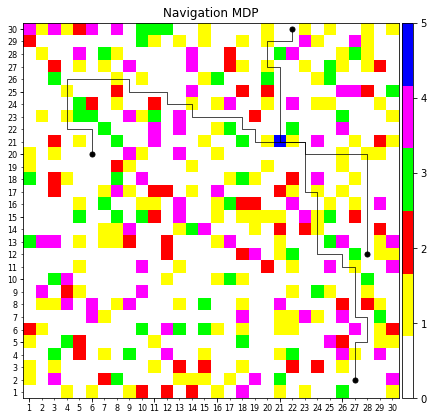

In [4]:
nvmdp.visualize_grid(trajectories=D)

## Experiment 1 features

In [5]:
def sample_data(nvmdp, n_trajectory, phi=None):
    """
    Args:
        n_trajectory: number of trajectories to sample

    Returns:
        [[phi(s1), phi(s3), ...], [phi(s1), phi(s3), ...], ...], where phi is one-hot encoded vector 
                of the cell type of a given state  
    """
    D_actions = []
    D_states = []
    
    action_to_idx = {a:i for i,a in enumerate(nvmdp.actions)}
    
    for _ in range(n_trajectory):
        action_seq, state_seq = value_iter.plan(nvmdp.get_random_init_state())
        #print(len(action_seq), len(state_seq))
        if phi is not None:
            D_states.append([phi(s)for s in state_seq])
        else:
            D_states.append(state_seq)
        D_actions.append([action_to_idx[a] for a in action_seq])
    return D_states, D_actions

def feature_long_horizon(nvmdp, x, y):
    row,col = nvmdp._xy_to_rowcol(x,y)
    if (x, y) in nvmdp.goal_locs:
        return np.zeros(len(nvmdp.cell_types), dtype=np.float32)
    else:
        return np.eye(len(nvmdp.cell_types))[nvmdp.cells[row, col]]
    
def feature_short_horizon(nvmdp, x, y):
    row,col = nvmdp._xy_to_rowcol(x,y)
    return np.hstack((feature_long_horizon(nvmdp, x, y), nvmdp.get_cell_distance_features()[row, col]))

In [6]:
np.random.seed(0)
N_tau = 8
phi_long=lambda mdp_state: feature_long_horizon(nvmdp, mdp_state.x, mdp_state.y)
phi_short=lambda mdp_state: feature_short_horizon(nvmdp, mdp_state.x, mdp_state.y)
D_states, D_actions = sample_data(nvmdp, N_tau, phi=phi_short)

In [7]:
[s for s in D_states[0][:5]]

[array([1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.41421354, 3.1622777 , 1.41421354, 2.23606801]),
 array([1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 2.23606801, 2.23606801, 1.41421354]),
 array([0.        , 1.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 1.41421354, 3.1622777 , 1.        ]),
 array([1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 1.        , 2.82842708, 1.        ]),
 array([1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 2.        , 2.23606801, 1.41421354])]

## Reference

[1] MacGlashan, James, and Michael L. Littman. "Between Imitation and Intention Learning." IJCAI. 2015.